<a href="https://colab.research.google.com/github/Drankenstain/Data_Analytics/blob/main/ARIMA_Data_Inflation_in_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LC01 - Kelompok 17**

link Dataset: https://www.kaggle.com/datasets/sazidthe1/global-inflation-data

Metode: Time Serial Models (ARIMA)

**Make Directory and Download Dataset**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d sazidthe1/global-inflation-data

Dataset URL: https://www.kaggle.com/datasets/sazidthe1/global-inflation-data
License(s): other
  0% 0.00/14.4k [00:00<?, ?B/s]
100% 14.4k/14.4k [00:00<00:00, 26.4MB/s]


In [ ]:
!unzip -q global-inflation-data.zip

**Import** **Library**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
df = pd.read_csv('global_inflation_data.csv')
df.describe()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,140.000000,144.000000,145.000000,145.000000,145.000000,145.000000,145.000000,147.000000,147.000000,147.000000,...,194.000000,194.000000,195.000000,195.000000,195.000000,194.000000,194.000000,194.000000,192.000000,191.000000
mean,21.757143,17.796528,17.029655,19.177241,26.979310,103.215172,25.262069,111.294558,58.635374,101.246259,...,4.116186,6.594742,7.656821,339.688359,107.294872,19.832680,16.577629,13.616031,13.736458,9.309424
std,33.656118,18.992691,22.797064,34.806824,111.889811,975.748316,86.931210,1081.094434,400.370989,679.792142,...,10.763149,31.096216,34.954954,4681.227548,1425.256254,173.722612,117.154632,25.282229,39.667874,25.195589
min,-7.300000,0.000000,-0.900000,-8.500000,-7.400000,-16.000000,-17.600000,-31.200000,-13.000000,-9.600000,...,-3.800000,-5.600000,-13.300000,-44.400000,-3.200000,-2.600000,-3.000000,-3.200000,-0.800000,1.200000
25%,9.550000,8.600000,6.100000,5.000000,3.800000,2.800000,1.800000,2.150000,2.550000,3.350000,...,0.100000,0.100000,1.150000,1.300000,0.800000,0.400000,1.925000,5.500000,4.000000,2.800000
50%,13.850000,12.500000,10.300000,8.700000,8.000000,7.100000,5.800000,5.900000,6.800000,6.900000,...,1.500000,1.500000,2.400000,2.500000,2.200000,1.900000,3.500000,8.100000,5.800000,4.000000
75%,20.525000,19.800000,16.700000,16.000000,17.100000,16.800000,18.200000,16.650000,17.800000,16.700000,...,4.800000,5.125000,5.200000,4.300000,4.000000,4.575000,5.975000,11.975000,9.925000,5.800000
max,316.600000,116.800000,123.600000,275.600000,1281.300000,11749.600000,885.200000,13109.500000,4775.200000,7428.700000,...,121.700000,346.100000,438.100000,65374.100000,19906.000000,2355.100000,1588.500000,193.400000,360.000000,222.400000


**Data Visualization**

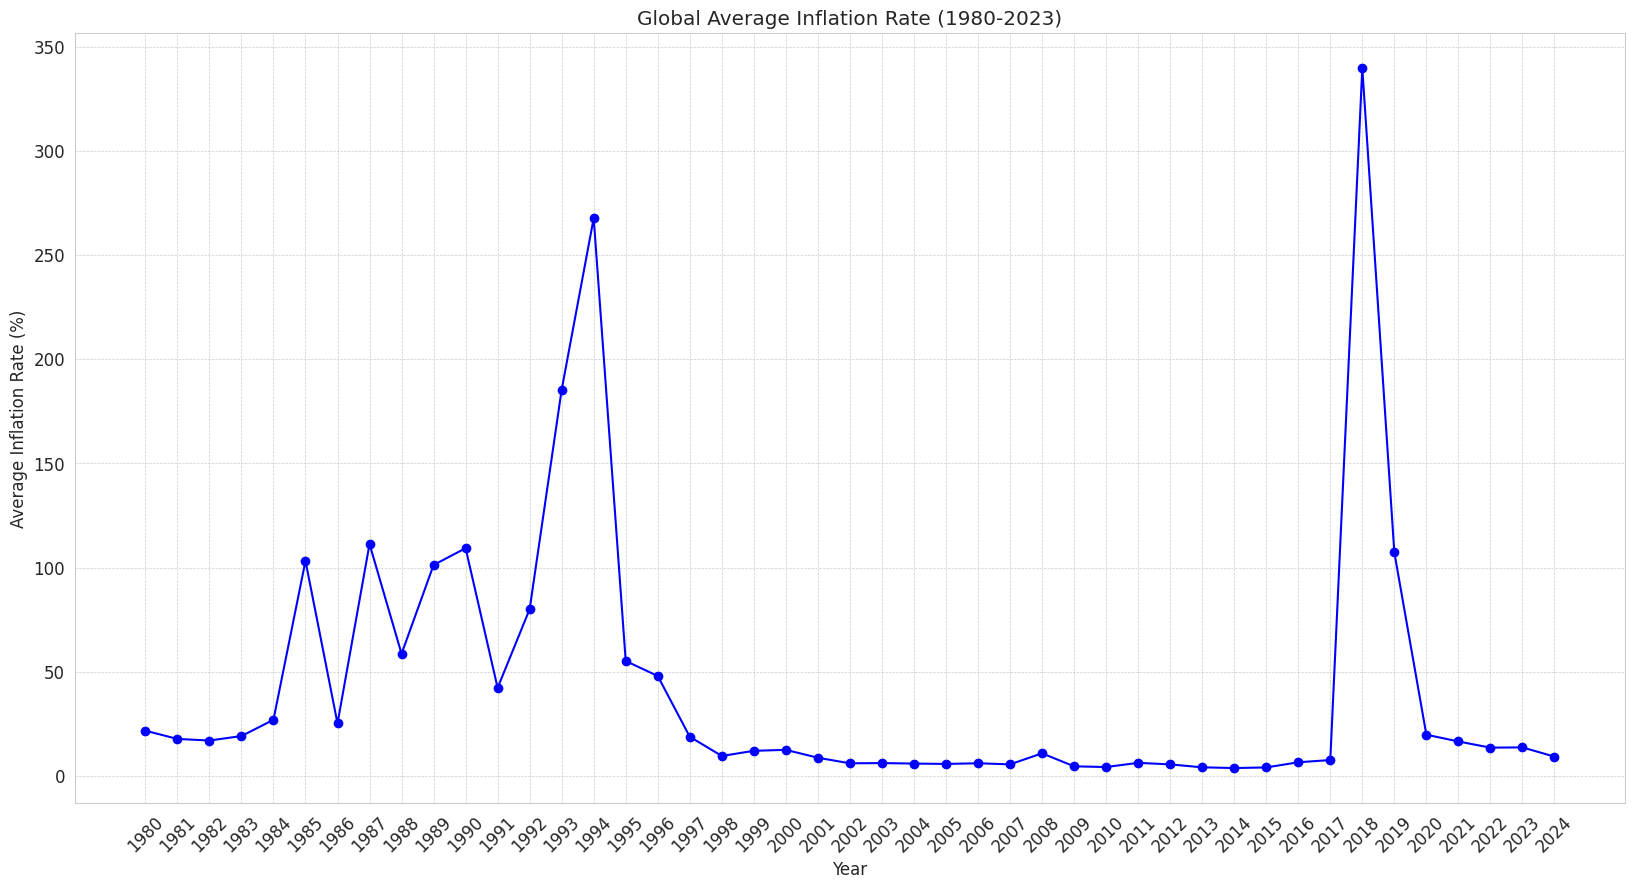

In [ ]:
# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (20, 10)})

# Preparing data for visualization: Averaging inflation rates for each year across all countries
average_inflation_per_year = df.loc[:, '1980':'2024'].mean().dropna()

# Plotting the global average inflation rate over time
plt.plot(average_inflation_per_year.index, average_inflation_per_year.values, marker='o', linestyle='-', color='blue')
plt.title('Global Average Inflation Rate (1980-2023)')
plt.xlabel('Year')
plt.ylabel('Average Inflation Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Assuming we have a mapping of countries to regions
regions = {
    'North America': ['United States', 'Canada', 'Mexico'],
    'Europe': ['Germany', 'France', 'United Kingdom'],
    'Asia': ['China', 'Japan', 'India'],
    # Add other regions and countries as needed
}

# Create a new column 'region' in the dataframe based on the country name
def map_country_to_region(country_name):
    for region, countries in regions.items():
        if country_name in countries:
            return region
    return 'Other'

df['region'] = df['country_name'].apply(map_country_to_region)


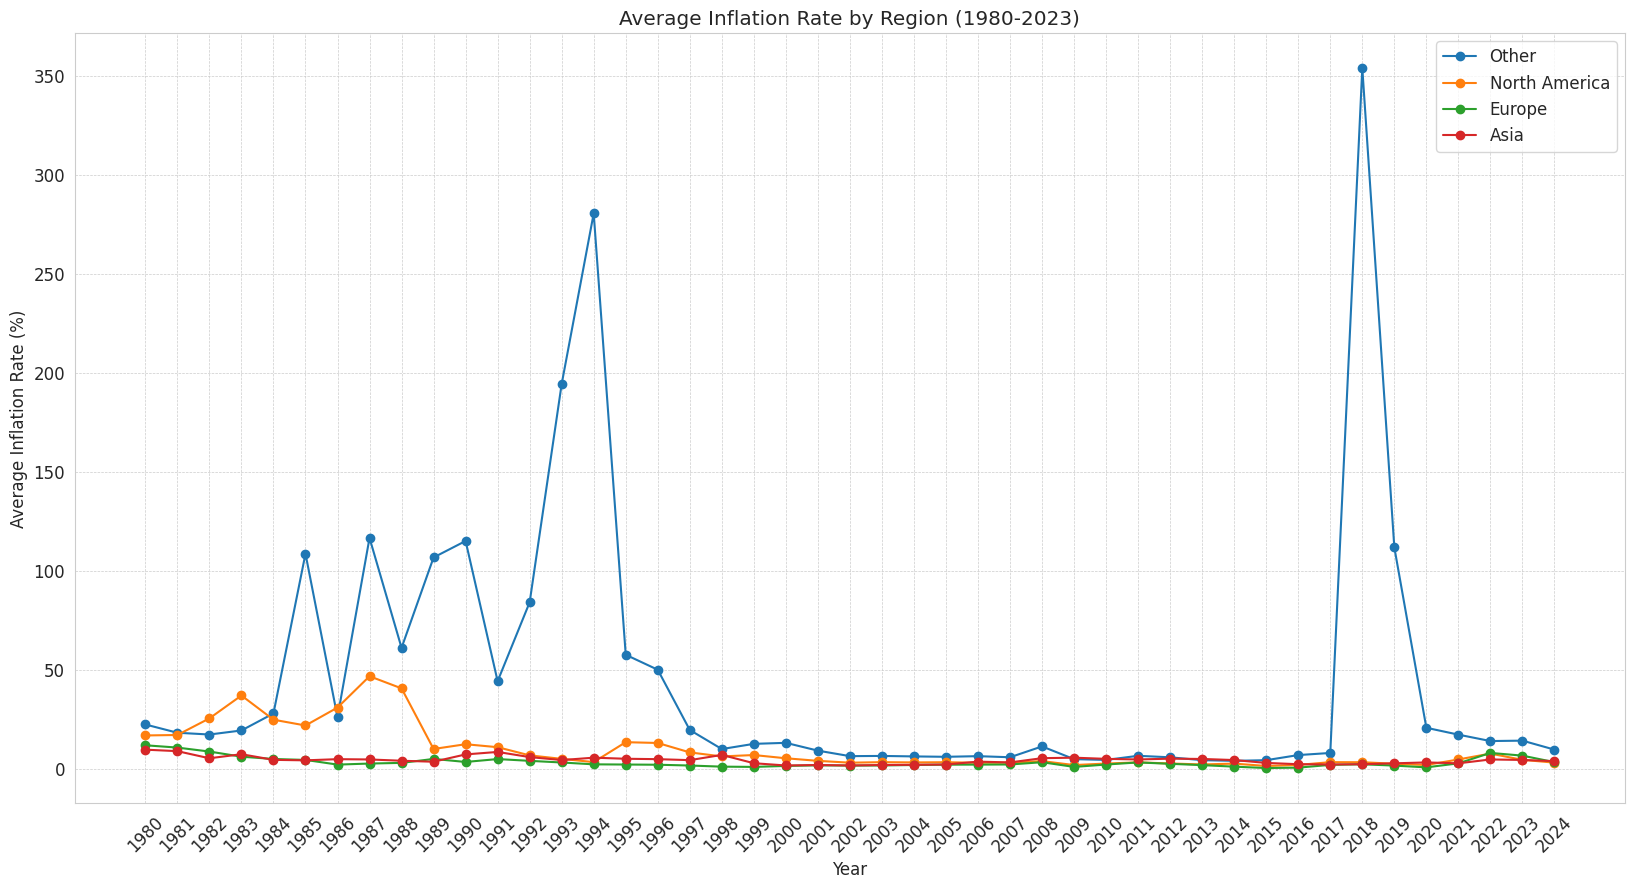

In [ ]:
# Visualize the average inflation rate by region over time
for region in df['region'].unique():
    regional_data = df[df['region'] == region]
    average_inflation_per_year = regional_data.loc[:, '1980':'2024'].mean().dropna()

    plt.plot(average_inflation_per_year.index, average_inflation_per_year.values, marker='o', linestyle='-', label=region)

plt.title('Average Inflation Rate by Region (1980-2023)')
plt.xlabel('Year')
plt.ylabel('Average Inflation Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

**Data Preprocessing**

In [ ]:
# Ensure all data is numeric, coerce any non-numeric to NaN which will then be filled
numeric_df = df.drop(columns=['country_name', 'indicator_name', 'region']).apply(pd.to_numeric, errors='coerce')

# Fill NaN values using backfill, then forward fill to minimize gaps
df_filled = numeric_df.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

# Calculate the year-over-year percentage change
df_yoy = df_filled.pct_change(axis=1) * 100

# Replace any potential infinities with NaN
df_yoy.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values, which now only represent the initial year where pct_change cannot be calculated
df_yoy.fillna(0, inplace=True)

# Re-insert the country_name column for the heatmap's y-axis labels
df_yoy.insert(0, 'country_name', df['country_name'])

# Now prepare for heatmap
# Exclude 'country_name' for the heatmap data
df_yoy_for_heatmap = df_yoy.set_index('country_name')


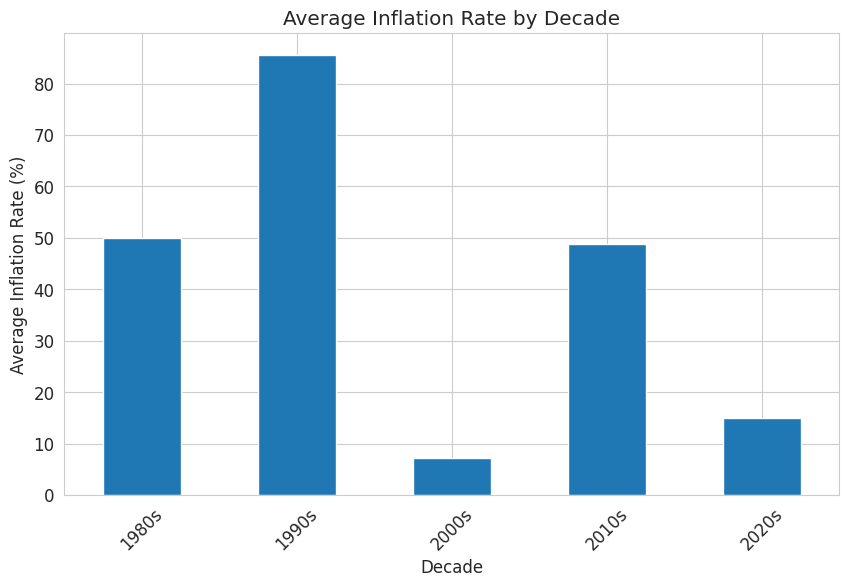

In [ ]:
# Function to map years to decades
def map_year_to_decade(year):
    return f"{str(year)[:3]}0s"

# Apply the function to columns (years) and aggregate data by decade
df_decades = df.drop(columns=['country_name', 'indicator_name', 'region']).apply(pd.to_numeric, errors='coerce')
decades = df_decades.columns.to_series().apply(map_year_to_decade)

# Transpose the DataFrame, group by decade, take the mean, and transpose back
df_decade_comparison = df_decades.T.groupby(decades).mean().T

# Now calculate the mean across all countries for each decade
average_inflation_by_decade = df_decade_comparison.mean()

# Plot the average inflation by decade
average_inflation_by_decade.plot(kind='bar', figsize=(10, 6))
plt.title('Average Inflation Rate by Decade')
plt.ylabel('Average Inflation Rate (%)')
plt.xlabel('Decade')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Region Visualization**

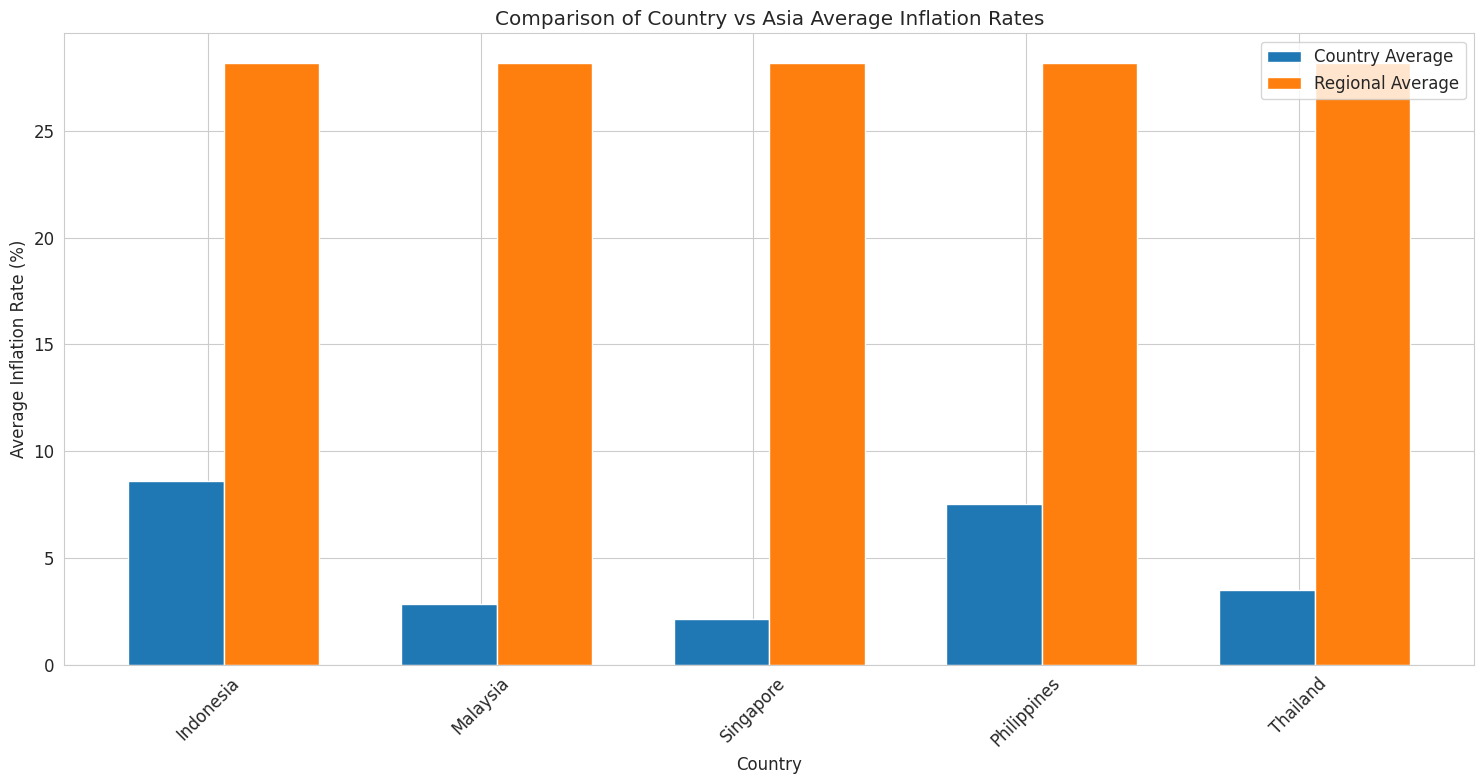

In [ ]:
# Example region mapping
# First, we define a list of countries by region
asia_countries = [
    'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei Darussalam', 'Cambodia',
    'China, People\'s Republic of', 'Georgia', 'Hong Kong SAR', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel',
    'Japan', 'Jordan', 'Kazakhstan', 'Korea, Republic of', 'Kuwait', 'Kyrgyz Republic', 'Lao P.D.R.', 'Lebanon',
    'Macao SAR', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'Oman', 'Pakistan', 'Philippines',
    'Qatar', 'Saudi Arabia', 'Singapore', 'Sri Lanka', 'Syria', 'Taiwan Province of China', 'Tajikistan',
    'Thailand', 'Timor-Leste', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'
]

europe_countries = [
    'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
    'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
    'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russian Federation',
    'San Marino', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Türkiye, Republic of',
    'Ukraine', 'United Kingdom'
]

africa_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep. of the', 'Congo, Republic of',
    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia, The',
    'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi',
    'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
    'São Tomé and Príncipe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
    'South Sudan, Republic of', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

americas_countries = [
    'Antigua and Barbuda', 'Argentina', 'Bahamas, The', 'Barbados', 'Belize', 'Bolivia', 'Brazil',
    'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador',
    'El Salvador', 'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Mexico',
    'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia',
    'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States', 'Uruguay', 'Venezuela'
]

oceania_countries = [
    'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia, Fed. States of', 'Nauru',
    'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'
]

# Now we create the region mapping dictionary
region_mapping = {country: 'Asia' for country in asia_countries}
region_mapping.update({country: 'Europe' for country in europe_countries})
region_mapping.update({country: 'Africa' for country in africa_countries})
region_mapping.update({country: 'Americas' for country in americas_countries})
region_mapping.update({country: 'Oceania' for country in oceania_countries})

df['region'] = df['country_name'].apply(lambda x: region_mapping.get(x, 'Other'))

# Select only numeric columns for the mean calculation (excluding 'country_name', 'indicator_name', and 'region')
numeric_cols = df.columns.drop(['country_name', 'indicator_name', 'region'])
df_numeric = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Add the 'region' column back to the numeric DataFrame for grouping
df_numeric['region'] = df['region']

# Then, calculate the mean inflation rate by region
df_region_comparison = df_numeric.groupby('region').mean()

# Define countries to visualize
countries_to_visualize = ['Indonesia', 'Malaysia', 'Singapore', 'Philippines', 'Thailand']

# Initialize lists to store plot data
countries = []
country_inflation_rates = []
region_inflation_rates = []

# Populate the lists with data
for country in countries_to_visualize:
    country_df = df[df['country_name'] == country]
    if not country_df.empty:
        region = country_df['region'].iloc[0]
        country_data = country_df[numeric_cols].mean(axis=1).mean()
        region_data = df_region_comparison.loc[region, numeric_cols].mean()

        countries.append(country)
        country_inflation_rates.append(country_data)
        region_inflation_rates.append(region_data)
    else:
        print(f"No data found for country: {country}")

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(countries))

bars1 = plt.bar(index, country_inflation_rates, bar_width, label='Country Average')
bars2 = plt.bar(index + bar_width, region_inflation_rates, bar_width, label='Regional Average')

plt.xlabel('Country')
plt.ylabel('Average Inflation Rate (%)')
plt.title('Comparison of Country vs Asia Average Inflation Rates')
plt.xticks(index + bar_width / 3, countries, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Correct approach for calculating moving averages
window_size = 5

# Create a new DataFrame for moving averages to avoid the ValueError
df_ma = pd.DataFrame()

# Calculate moving averages
for col in numeric_cols:
    # Transpose, apply rolling, transpose back, and then take the mean
    df_ma[f'{col}_MA'] = df[numeric_cols].T.rolling(window=window_size).mean().T[col]

# Incorporate country names and regions back into the moving average DataFrame
df_ma['country_name'] = df['country_name']
df_ma['region'] = df['region']

# Example of accessing the moving average for Indonesia in 2000
print(df_ma[df_ma['country_name'] == 'Indonesia']['2000_MA'])

78    19.36
Name: 2000_MA, dtype: float64


In [ ]:
# Exclude non-numeric columns and ensure df_numeric contains only numeric year columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

# Fill NaN values in df_numeric using forward and backward filling
df_filled = df_numeric.ffill(axis=1).bfill(axis=1)

# Standardize the numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filled)


In [ ]:
# Identify year columns explicitly
# Assuming all columns except for 'country_name' and 'indicator_name' are year columns
year_columns = df.columns.drop(['country_name', 'indicator_name'])

# Transform the dataset from wide format to long format, including only year columns
df_long = df.melt(id_vars=['country_name'], value_vars=year_columns, var_name='Year', value_name='InflationRate')

# Exclude rows where 'Year' is 'indicator_name' or any other non-year value
df_long = df_long[df_long['Year'].apply(lambda x: x.isnumeric())]

# Convert 'Year' to a datetime type
df_long['Year'] = pd.to_datetime(df_long['Year'], format='%Y')

# Now, df_long has a structure suitable for time series analysis: 'Country', 'Year', 'InflationRate'


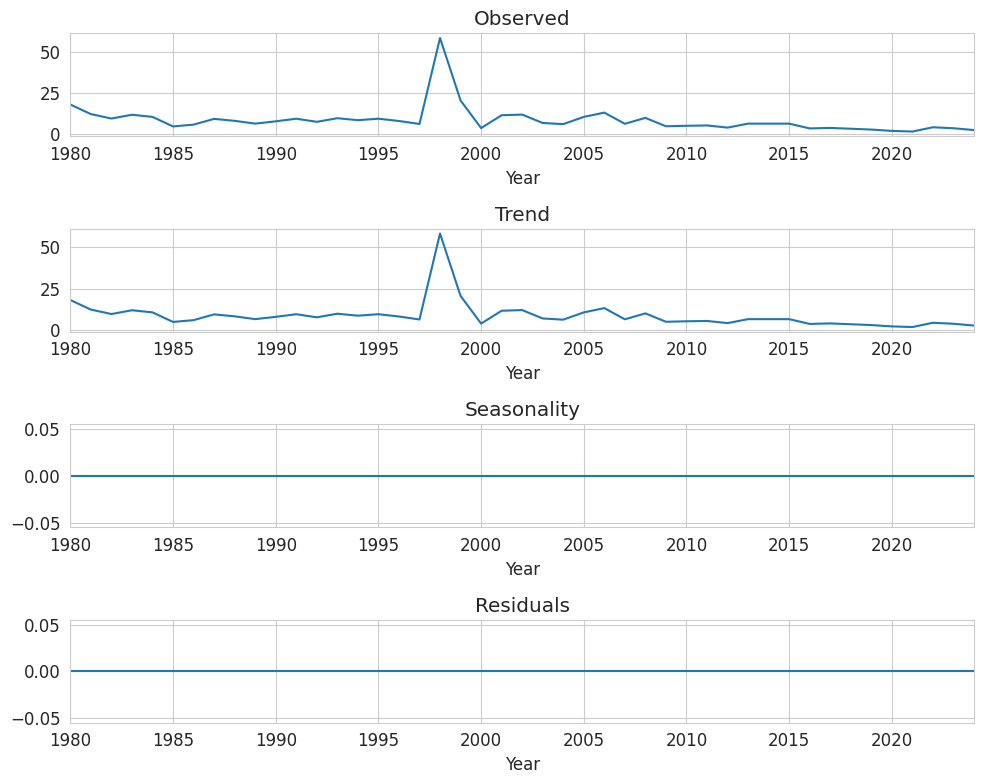

In [ ]:
# Assuming df_long has 'country_name', 'Year', and 'InflationRate' columns
# and you want to analyze the time series for a specific country, e.g., 'United States'
country_df = df_long[df_long['country_name'] == 'Indonesia'].copy()

# Ensure 'Year' is in datetime format and set it as the index
country_df['Year'] = pd.to_datetime(country_df['Year'])
country_df.set_index('Year', inplace=True)

# Decompose the time series of 'InflationRate'
decomposition = seasonal_decompose(country_df['InflationRate'], model='additive', period=1)

# Plot the decomposed components
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax[0], legend=False, title='Observed')
decomposition.trend.plot(ax=ax[1], legend=False, title='Trend')
decomposition.seasonal.plot(ax=ax[2], legend=False, title='Seasonality')
decomposition.resid.plot(ax=ax[3], legend=False, title='Residuals')

plt.tight_layout()
plt.show()


**Model ARIMA(AutoRegressive Integrated Moving Average) Prediction**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


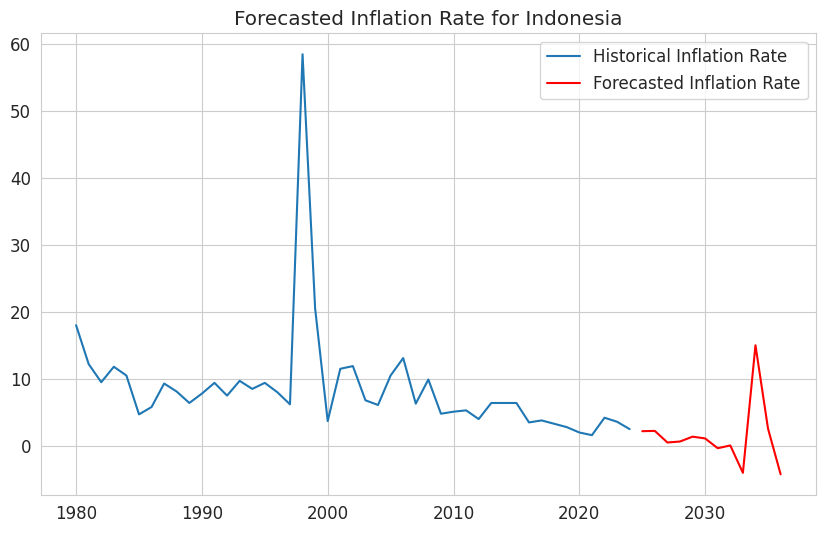

In [ ]:
# Assuming df_long is correctly formatted and available
country_name = 'Indonesia'
country_data = df_long[df_long['country_name'] == country_name].copy()

# Ensure 'Year' is datetime type and set as index
country_data['Year'] = pd.to_datetime(country_data['Year'])
country_data.set_index('Year', inplace=True)

# Convert 'InflationRate' to numeric, handling non-numeric values
country_data['InflationRate'] = pd.to_numeric(country_data['InflationRate'], errors='coerce')

# Drop any rows with NaN values in 'InflationRate' to avoid errors in modeling
country_data.dropna(subset=['InflationRate'], inplace=True)

# SARIMAX Model parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Build and fit the SARIMA model on 'InflationRate'
model = SARIMAX(country_data['InflationRate'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Forecast future values
forecast = results.forecast(steps=12)

# Plotting the forecast alongside historical data
plt.figure(figsize=(10, 6))
plt.plot(country_data['InflationRate'], label='Historical Inflation Rate')
plt.plot(forecast, label='Forecasted Inflation Rate', color='red')
plt.legend()
plt.title(f'Forecasted Inflation Rate for {country_name}')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 14.944


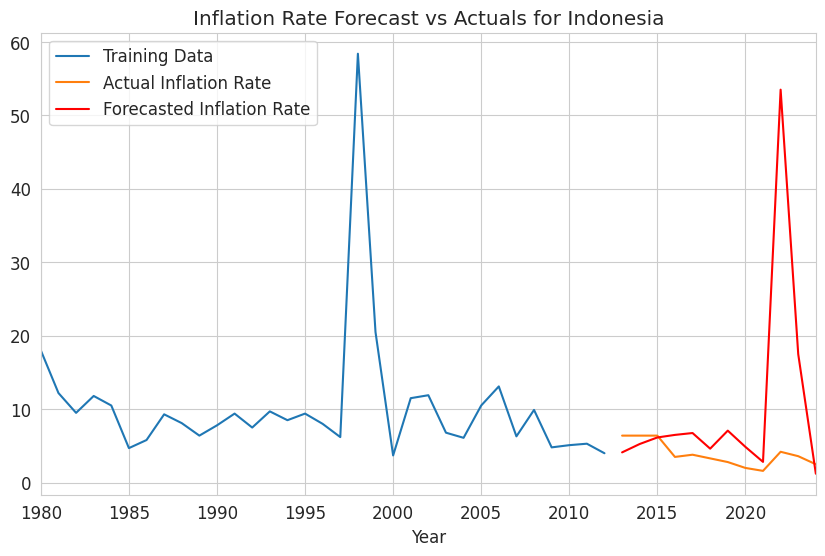

In [ ]:
# Ensure 'InflationRate' is numeric and handle NaN values
country_data['InflationRate'] = pd.to_numeric(country_data['InflationRate'], errors='coerce')
country_data.dropna(inplace=True)

# Assuming the SARIMAX parameters are as before
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

# Split the data into training and testing sets as before
split_point = len(country_data) - 12
train = country_data.iloc[:split_point]['InflationRate']
test = country_data.iloc[split_point:]['InflationRate']

# Fit the SARIMAX model on the training set
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Forecast on the testing set
forecast = results.forecast(steps=12)

# Calculate RMSE for the forecast
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)

# Plotting for visualization
plt.figure(figsize=(10, 6))
train.plot(label='Training Data')
test.plot(label='Actual Inflation Rate')
forecast.plot(label='Forecasted Inflation Rate', color='red')
plt.legend()
plt.title(f'Inflation Rate Forecast vs Actuals for {country_name}')
plt.show()
